# Injection Testing

The `alias.injection` submodule provides tools for testing various methods of detecting anomalous emmision lines in spectra.

The module contains the `injection_test` function, which performs a given number of these individual tests and returns their results for analysis. The proper usage of this function is demontrated below.

Before running injection tests, the following steps must be completed:

- Creating (or loading) a dataset
- Defining the detection logic

In [1]:
# Import needed libraries

import alias
import alias.injection as inj

import numpy as np
import matplotlib.pyplot as plt

/mnt_home/jhand/alias/alias/injection.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


## Creating a Dataset

First we must create a dataset to test with, contained in a `Dataset` object. In this case, we are creating a spectrum consisting of 8000 datapoints, each with a relative flux value of 1+/-0.01.

Alternatively, a dataset can be loaded from a collection of fits files using the `load_dataset` function of the `alias` module.

In [2]:
wave = np.array(range(0, 8000), dtype=float)
flux = np.array([[1.0]*8000], dtype=float)
ivar = np.array([[10000.0]*8000], dtype=float)

ds = alias.Dataset(wave, flux, ivar)

## Defining the Detection Function

The last step before running the test is creating a function containing the logic of our detection method must be written. This function is required to take three parameters, the wavelength array, the flux array, and the inverse-variance array. It is not required to use all of them, but it must accept them. The function can assume that these arrays are all the same length.

The function must also return an array of the same length as the three inputs. This array is interpretted as a "weirdness" metric, with higher values corresponding to datapoints more likely to be part of an anomalous emission line.

When computing the results, the tester considers a weirdness value of more than one to be a detection. If there is at least one such detection within 3 pixels of the injected line, the tester considers the line to have been successfully detected. The tester does not reward multiple detections in this range. Any detections outside this range are considered false positives.

In [3]:
def test_detector(wave, flux, ivar):
    # Very simple, totally not useful detection method that happens to work fairly well with flat spectra.
    return flux - 0.01

## Running the Test

Now that all the prerequisites are finished, the tests can be actually run. This is done using the `injection_test` method provided by the `alias.injection` submodule.

The function takes the following as parameters:

- A dataset
- A line-spread function
- The detection logic
- The number of tests to run
- The minimum amplitude of injected lines
- The maximum amplitude

The `injection` submodule provides the `defaultLSF` variable to use for the line-spread function, but a different one can be used if desired. The remaining parameters are fairly self-explanatory.

In [4]:
results = inj.injection_test(ds, inj.defaultLSF, test_detector, 500, 0.01, 0.1)

## Interpreting the Results

The injection_test returns a two-dimensional array with the results of the tests. Each row of the array corresponds to each test performed. The columns contain the following:

- The index of the spectrum usind for the test
- The wavelegnth at which the line was injected
- The amplitude of the injected line
- Whether the detection was successful
- The number of false positives

Using this data, various metrics of the detector's performance can be guaged:

- How often it successfully identifies the injected line (it's sensitivity)
- How often it falsely labels normal features as anomalous

Additionally, these performance metrics can be plotted as a function of wavelength and the spectrum used, to identify individual spectra or regions of spectra that cause issues for the detector.

In [5]:
print('Sensitivity: %.2f%%' %(100*sum(results[:,3] == True)/len(results)))
print('Efficiency: %.3f/spectrum' %np.mean(results[:,4]))

Sensitivity: 99.40%
Efficiency: 0.006/spectrum


As you can see, this method works very well on simple flat spectra, as it can detect 99.8% of the injected lines, while never producing a false positive.

It goes without saying that this method only works on these flat spectra. We can demonstrate this by loading an actual dataset and re-running the test.

In [6]:
with open('../data/sample_star_urls_rev2', 'r') as f:
    urls = f.read().splitlines()

files = [ '../data/spectra_rev2/%s' %url.split('/')[-1] for url in urls ]

ds_real = alias.loadDataset(files)

results = inj.injection_test(ds_real, inj.defaultLSF, test_detector, 500, 0.01, 0.1)

print('Sensitivity: %.2f%%' %(100*sum(results[:,3] > 0.5)/len(results)))
print('Efficiency: %.3f/spectrum' %np.mean(results[:,4]))

/mnt_home/jhand/alias/alias/__init__.py:58: RuntimeWarning: divide by zero encountered in power
  spec_ivar_parts = np.array(hdul[2].data)**-2


Sensitivity: 65.00%
Efficiency: 3745.380/spectrum


Further analysis can be performed by, for example, looking at the regions of the spectrum where the detector had difficulty recovering the injected line. 

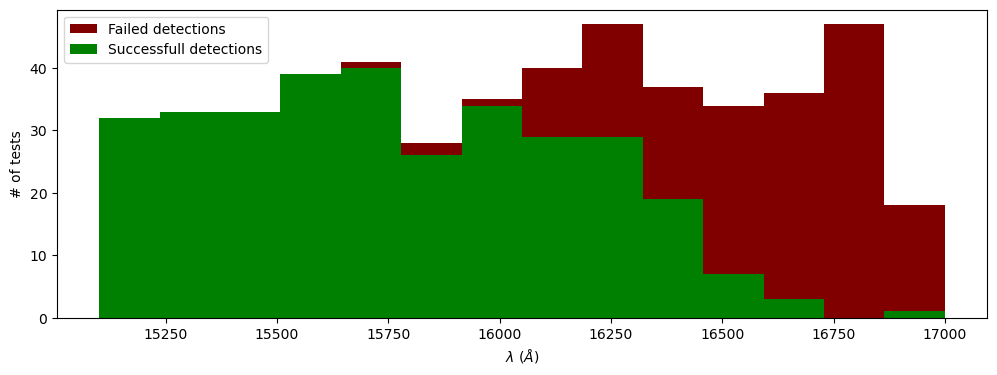

In [7]:
bins = np.linspace(np.min(ds_real.wave), np.max(ds_real.wave), 15)

plt.figure(figsize=(12,4))

plt.hist(results[:,1], bins=bins, color='maroon', label='Failed detections')
plt.hist(results[results[:,3] > 0.5,1], bins=bins, color='green', label='Successfull detections')

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'# of tests')
_ = plt.legend()

As can be seen in the above figure, the detection method is more sensitive for shorter wavelengths, but much less sensitive at longer wavelengths.

Note that this does not necessarily mean the method works well at shorter wavelengths, as it is likely not very efficient at these wavelengths.